<a href="https://colab.research.google.com/github/jamesgolden1/llms-are-llms/blob/main/notebooks/gemma_3/gemma_4B_jax_float32_lanczos_400_tokens_bfloat16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# %load

In [ ]:
try:
    from gemma import gm
except:
    !pip install -q gemma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 89.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.0/181.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.3/492.3 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.9 MB/s eta 0:00:00

In [ ]:
#@title Gemma Layers
%%writefile /usr/local/lib/python3.11/dist-packages/gemma/layers.py
# Copyright 2024 DeepMind Technologies Limited.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Base layers."""

from flax import linen as nn
import jax
import jax.numpy as jnp


class Einsum(nn.Module):
  """Einsum is a convenience module for parameterized tensor multiplication."""

  shape: tuple[int, ...]
  weight_name: str = 'w'
  initializer: nn.initializers.Initializer = nn.initializers.normal()
  dtype: jnp.dtype | None = None

  @nn.compact
  def __call__(self, eqn: str, x: jax.Array) -> jax.Array:
    w = self.param(
        self.weight_name,
        self.initializer,
        self.shape,
        self.dtype if self.dtype is not None else None,
    )
    return jnp.einsum(eqn, x, w)


class RMSNorm(nn.Module):
  """RMSNorm layer."""

  @nn.compact
  def __call__(self, x):
    scale = self.param('scale', nn.initializers.zeros_init(), (x.shape[-1]))
    var = jnp.mean(jnp.square(x), axis=-1, keepdims=True)

    # Jax.lax.rsqrt is used because it returns different floats than
    # jnp.reciprocal(jnp.sqrt(var + 1e-06))
    normed_inputs = x * jax.lax.stop_gradient(jax.lax.rsqrt(var + 1e-06))

    # normed_inputs is a rank-K tensor, K > 1 (K is typically 2 or 3). scale is
    # a rank-1 tensor. To avoid implicit rank-promotion, reshape scale to
    # a (1, ..., 1, D) tensor, so the rank of scale matches normed_inputs.
    scale = jax.lax.stop_gradient(jnp.expand_dims(scale, axis=range(len(x.shape) - 1)))
    normed_inputs = normed_inputs * (1 + scale)
    return normed_inputs


Writing /usr/local/lib/python3.11/dist-packages/gemma/layers.py


In [ ]:
#@title Gemma Modules
%%writefile /usr/local/lib/python3.11/dist-packages/gemma/modules.py
# Copyright 2024 DeepMind Technologies Limited.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Transformer sub-modules."""

import enum
from flax import linen as nn
from gemma import layers
from gemma import positional_embeddings
import jax
import jax.numpy as jnp

from jax._src.typing import Array, ArrayLike, DType, DTypeLike

K_MASK = -2.3819763e38  # Set to a large negative number.
DEFAULT_ROPE_BASE_FREQUENCY = 10_000
DEFAULT_ROPE_SCALE_FACTOR = 1.0
LayerCache = dict[str, jax.Array]


def _create_sliding_mask(
    segment_pos: jnp.ndarray,
    end_index: int,
    cache_len: int,
    sliding_window_size: int,
):
  """Creates mask for sliding window attention."""
  total_tokens = end_index + segment_pos.shape[1]  # cached + processing tokens

  def _reconstruct_rotated_cache_positions():
    cache_positions = jnp.arange(cache_len) + total_tokens - cache_len
    cache_positions = (
        jnp.zeros_like(cache_positions)
        # kv were placed at index (position_id % cache_len) in the cache.
        .at[cache_positions % cache_len].set(cache_positions)
    )
    return cache_positions

  # Reconstruct position_ids for cached kv.
  cache_positions = jax.lax.cond(
      total_tokens <= cache_len,
      lambda: jnp.arange(cache_len),
      _reconstruct_rotated_cache_positions,
  )

  cache_positions = cache_positions[None, None, :]  # [1, 1, cache_len]
  segment_pos = segment_pos[:, :, None]  # [B, seq_len, 1]
  sliding_mask = cache_positions > segment_pos - sliding_window_size
  sliding_mask *= cache_positions < segment_pos + sliding_window_size
  return sliding_mask


class AttentionType(enum.Enum):
  GLOBAL = 1
  LOCAL_SLIDING = 2


class Embedder(nn.Module):
  """Embedder module."""

  vocab_size: int
  embed_dim: int

  vision_proj_dim: int | None = None

  def setup(self):
    self.input_embedding_table = self.param(
        'input_embedding',
        nn.initializers.normal(),
        (self.vocab_size, self.embed_dim),
    )

    # For the multi-modal models, the encoder has additional parameters:
    # * `mm_soft_embedding_norm` and `mm_input_projection`: Those weights
    #   serve to project the soft tokens from the image encoder into the
    #   embedding space of the text encoder. Those tokens are then merged with
    #   the text tokens inside `Transformer._include_vision_embeddings`.
    if self.vision_proj_dim:
      self.mm_soft_embedding_norm = layers.RMSNorm()
      self.mm_input_projection = layers.Einsum(
          (self.vision_proj_dim, self.embed_dim)
      )

  def encode(self, x: jax.Array) -> jax.Array:
    x = self.input_embedding_table[(x,)]
    x *= jnp.sqrt(self.embed_dim).astype(x.dtype)
    return x

  def decode(self, x: jax.Array) -> jax.Array:
    return jnp.dot(x, self.input_embedding_table.T)

  def encode_vision(self, x: jax.Array) -> jax.Array:
    """Projects siglip embeddings to the embedding space of the text encoder."""
    x = self.mm_soft_embedding_norm(x)
    x = self.mm_input_projection('...tm,md->...td', x)
    return x


class Attention(nn.Module):
  """Attention module."""

  num_heads: int
  num_kv_heads: int
  features: int
  head_dim: int
  attn_type: AttentionType
  query_pre_attn_scalar: float
  rope_base_frequency: int = DEFAULT_ROPE_BASE_FREQUENCY
  rope_scale_factor: float = DEFAULT_ROPE_SCALE_FACTOR
  attn_logits_soft_cap: float | None = None
  sliding_window_size: int | None = None
  use_qk_norm: bool = False

  @property
  def use_qkv_einsum(self):
    return self.num_kv_heads == self.num_heads

  @property
  def use_gqa(self):
    return self.num_kv_heads != self.num_heads and self.num_kv_heads > 1

  def setup(self):
    self.attn_vec_einsum = layers.Einsum(
        shape=(self.num_heads, self.head_dim, self.features),
    )

    if self.use_qkv_einsum:
      self.qkv_einsum = layers.Einsum(
          shape=(3, self.num_heads, self.features, self.head_dim),
      )
    else:
      self.q_einsum = layers.Einsum(
          shape=(self.num_heads, self.features, self.head_dim),
      )
      self.kv_einsum = layers.Einsum(
          shape=(2, self.num_kv_heads, self.features, self.head_dim),
      )
    if self.use_qk_norm:
      self._query_norm = layers.RMSNorm()
      self._key_norm = layers.RMSNorm()

  def __call__(
      self,
      x: jax.Array,
      segment_pos: jax.Array,
      cache: LayerCache | None,
      attn_mask: jax.Array,
  ) -> tuple[LayerCache | None, jax.Array]:
    seq_len = x.shape[1]

    if self.use_qkv_einsum:
      query_proj, key_proj, value_proj = self.qkv_einsum('BTD,SNDH->SBTNH', x)
    else:
      query_proj = self.q_einsum('BTD,NDH->BTNH', x)
      key_proj, value_proj = self.kv_einsum('BSD,CKDH->CBSKH', x)

    query_proj = jax.lax.stop_gradient(query_proj)
    key_proj = jax.lax.stop_gradient(key_proj)

    if self.use_qk_norm:
      query_proj = self._query_norm(query_proj)
      key_proj = self._key_norm(key_proj)

    query_proj = positional_embeddings.apply_rope(
        query_proj,
        segment_pos,
        base_frequency=self.rope_base_frequency,
        scale_factor=self.rope_scale_factor,
    )
    query_scaled = query_proj * self.query_pre_attn_scalar
    key_proj = positional_embeddings.apply_rope(
        key_proj,
        segment_pos,
        base_frequency=self.rope_base_frequency,
        scale_factor=self.rope_scale_factor,
    )

    query_proj = jax.lax.stop_gradient(query_proj)
    key_proj = jax.lax.stop_gradient(key_proj)

    # Cache is left aligned.
    # Save the KV values to the cache.
    if cache is not None:
      end_index = cache['end_index'][0]
      slice_indices = (0, end_index % cache['v'].shape[1], 0, 0)
      value_proj = jax.lax.dynamic_update_slice(
          cache['v'],
          value_proj,
          slice_indices,
      )
      key_proj = jax.lax.dynamic_update_slice(
          cache['k'], key_proj, slice_indices
      )

    if self.use_gqa:
      # Reshape matrices to enable einsums over groups.
      b, t, kg, h = query_scaled.shape
      query_scaled = query_scaled.reshape(
          (b, t, self.num_kv_heads, int(kg / self.num_kv_heads), h)
      )
      logits = jnp.einsum('BTKGH,BSKH->BTKGS', query_scaled, key_proj)
      b, t, k, g, s = logits.shape
      logits = logits.reshape((b, t, k * g, s))
    else:
      logits = jnp.einsum('BTNH,BSNH->BTNS', query_scaled, key_proj)

    if self.attn_logits_soft_cap is not None:
      logits = jnp.tanh(logits / self.attn_logits_soft_cap)
      logits = logits * self.attn_logits_soft_cap

    if self.attn_type == AttentionType.LOCAL_SLIDING:
      if self.sliding_window_size is None:
        raise ValueError(
            'Sliding_window_size must be set if Local Sliding attention type'
        )
      sliding_mask = _create_sliding_mask(
          segment_pos,
          end_index=cache['end_index'][0] if cache is not None else 0,
          # Derive cache length from attn_mask shape in case cache is None
          cache_len=attn_mask.shape[-1],
          sliding_window_size=self.sliding_window_size,
      )
      attn_mask *= sliding_mask

    padded_logits = jnp.where((jnp.expand_dims(attn_mask, -2)), logits, K_MASK)
    probs = jax.nn.softmax(padded_logits, axis=-1).astype(key_proj.dtype)
    if self.use_gqa:
      # Reshape matrices to enable einsums over groups.
      b, t, kg, h = probs.shape
      probs = probs.reshape(
          (b, t, self.num_kv_heads, int(kg / self.num_kv_heads), h)
      )
      encoded = jnp.einsum('BTKGS,BSKH->BTKGH', jax.lax.stop_gradient(probs), value_proj)
      b, t, k, g, h = encoded.shape
      encoded = encoded.reshape((b, t, k * g, h))
    else:
      encoded = jnp.einsum('BTNS,BSNH->BTNH', jax.lax.stop_gradient(probs), value_proj)
    attn_output = self.attn_vec_einsum('BTNH,NHD->BTD', encoded)

    if cache is not None:
      new_cache = {
          'v': value_proj,
          'k': key_proj,
          'end_index': cache['end_index'] + seq_len,
      }
    else:
      new_cache = None

    return new_cache, attn_output

  @classmethod
  def init_cache(
      cls,
      cache_size: int,
      num_heads: int,
      head_dim: int,
      batch_size: int,
      dtype: jnp.dtype = jnp.bfloat16,
  ) -> LayerCache:
    del cls  # not used
    return {
        'v': jnp.zeros(
            (batch_size, cache_size, num_heads, head_dim), dtype=dtype
        ),
        'k': jnp.zeros(
            (batch_size, cache_size, num_heads, head_dim), dtype=dtype
        ),
        'end_index': jnp.zeros((batch_size,), dtype=jnp.int32),
    }

def gelu_detached(x_arr: ArrayLike, approximate: bool = True) -> Array:
  r"""Gaussian error linear unit activation function.

  If ``approximate=False``, computes the element-wise function:

  .. math::
    \mathrm{gelu}(x) = \frac{x}{2} \left(\mathrm{erfc} \left(
      \frac{-x}{\sqrt{2}} \right) \right)

  If ``approximate=True``, uses the approximate formulation of GELU:

  .. math::
    \mathrm{gelu}(x) = \frac{x}{2} \left(1 + \mathrm{tanh} \left(
      \sqrt{\frac{2}{\pi}} \left(x + 0.044715 x^3 \right) \right) \right)

  For more information, see `Gaussian Error Linear Units (GELUs)
  <https://arxiv.org/abs/1606.08415>`_, section 2.

  Args:
    x: input array
    approximate: whether to use the approximate or exact formulation.
  """
#   [x_arr] = numpy_util.promote_args_inexact("gelu", x)
  import numpy as np
  if approximate:
    sqrt_2_over_pi = np.sqrt(2 / np.pi).astype(x_arr.dtype)
    cdf = 0.5 * (1.0 + jnp.tanh(sqrt_2_over_pi * (x_arr + 0.044715 * (x_arr ** 3))))
    cdf = jax.lax.stop_gradient(cdf)
    return x_arr * cdf
  else:
    sqrt_half = np.sqrt(0.5).astype(x_arr.dtype)
    return jnp.array(
        0.5 * x_arr * jax.lax.stop_gradient(lax.erfc(-x_arr * sqrt_half)), dtype=x_arr.dtype
    )

class FeedForward(nn.Module):
  """Feed forward module."""

  features: int
  hidden_dim: int
  transpose_gating_einsum: bool

  @nn.compact
  def __call__(self, x):
    # Some versions use an alternate parameter ordering that
    # transposes hidden_dim and features.
    if self.transpose_gating_einsum:
      eq = '...F,NHF->...NH'
      gating = layers.Einsum(
          shape=(2, self.hidden_dim, self.features),
          weight_name='gating_einsum',
      )
    else:
      eq = '...F,NFH->...NH'
      gating = layers.Einsum(
          shape=(2, self.features, self.hidden_dim),
          weight_name='gating_einsum',
      )

    # Use the same scope for backwards compatibility with existing checkpoints
    # created before using `layers.Einsum` here.
    nn.share_scope(self, gating)
    gate = gating(eq, x)
    activations =  jax.lax.stop_gradient(gelu_detached(gate[..., 0, :])) * gate[..., 1, :]

    # Down projection
    linear = layers.Einsum(
        shape=(self.hidden_dim, self.features),
        weight_name='linear',
    )
    nn.share_scope(self, linear)
    outputs = linear('...H,HF->...F', activations)

    return outputs


class Block(nn.Module):
  """Transformer block."""

  num_heads: int
  num_kv_heads: int
  embed_dim: int
  head_dim: int
  hidden_dim: int
  use_post_attn_norm: bool
  use_post_ffw_norm: bool
  attn_type: AttentionType
  query_pre_attn_scalar: float
  transpose_gating_einsum: bool
  rope_base_frequency: int = DEFAULT_ROPE_BASE_FREQUENCY
  rope_scale_factor: float = DEFAULT_ROPE_SCALE_FACTOR
  attn_logits_soft_cap: float | None = None
  sliding_window_size: int | None = None
  use_qk_norm: bool = False

  def setup(self):
    self.pre_attention_norm = layers.RMSNorm()
    self.attn = Attention(
        num_heads=self.num_heads,
        features=self.embed_dim,
        head_dim=self.head_dim,
        num_kv_heads=self.num_kv_heads,
        attn_type=self.attn_type,
        query_pre_attn_scalar=self.query_pre_attn_scalar,
        rope_base_frequency=self.rope_base_frequency,
        rope_scale_factor=self.rope_scale_factor,
        attn_logits_soft_cap=self.attn_logits_soft_cap,
        sliding_window_size=self.sliding_window_size,
        use_qk_norm=self.use_qk_norm,
    )
    self.post_attention_norm = None
    if self.use_post_attn_norm:
      self.post_attention_norm = layers.RMSNorm()

    self.pre_ffw_norm = layers.RMSNorm()
    self.mlp = FeedForward(
        features=self.embed_dim,
        hidden_dim=self.hidden_dim,
        transpose_gating_einsum=self.transpose_gating_einsum,
    )
    self.post_ffw_norm = None
    if self.use_post_ffw_norm:
      self.post_ffw_norm = layers.RMSNorm()

  def __call__(
      self,
      x: jax.Array,
      segment_pos: jax.Array,
      cache: LayerCache | None,
      attn_mask: jax.Array,
  ) -> tuple[LayerCache | None, jax.Array]:
    inputs_normalized = self.pre_attention_norm(x)
    cache, attn_output = self.attn(
        inputs_normalized,
        segment_pos,
        cache,
        attn_mask,
    )
    if self.post_attention_norm is not None:
      attn_output = self.post_attention_norm(attn_output)
    attn_output += x
    outputs = self.pre_ffw_norm(attn_output)
    outputs = self.mlp(outputs)
    if self.post_ffw_norm is not None:
      outputs = self.post_ffw_norm(outputs)
    outputs += attn_output
    return cache, outputs


Writing /usr/local/lib/python3.11/dist-packages/gemma/modules.py


In [ ]:
# Common imports
import os
import jax
import jax.numpy as jnp

# Gemma imports
from gemma import gm

In [ ]:
# Try these JAX memory management approaches
import os

# Method 1: Limit JAX memory pre-allocation
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5'

In [ ]:
# gm.ckpts.CheckpointPath.GEMMA3_1B_IT
# model = gm.nn.Gemma3_1B()

# params = gm.ckpts.load_params(gm.ckpts.CheckpointPath.GEMMA3_1B_IT, text_only=True)#, dtype=jnp.float32)

In [ ]:
model = gm.nn.Gemma3_4B()

params = gm.ckpts.load_params(gm.ckpts.CheckpointPath.GEMMA3_4B_IT, text_only=True)#, dtype=jnp.float32)

In [ ]:
# # Convert all parameters to float32
# def convert_to_float32(params):
#     """Convert all parameters from bfloat16 to float32"""
#     def convert_param(x):
#         if hasattr(x, 'dtype') and x.dtype == jnp.bfloat16:
#             return x.astype(jnp.float32)
#         return x

#     return jax.tree_map(convert_param, params)

# params = convert_to_float32(params)

In [ ]:
# Convert params to match model dtype
# params_f32 = convert_to_float32(params)

In [ ]:
model

Gemma3_4B(
    # attributes
    return_last_only = None
    dtype = bfloat16
    tokens = '__KEY_REQUIRED__'
    images = None
    config = TransformerConfig(num_embed=262144, embed_dim=2560, hidden_dim=10240, num_heads=8, head_dim=256, num_kv_heads=4, final_logit_softcap=None, use_post_attn_norm=True, use_post_ffw_norm=True, attention_types=(<AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.GLOBAL: 1>, <AttentionType.LOCAL_SLIDING: 2>, <AttentionType.LOCAL_SLIDING: 

In [ ]:
    # Check if vision components are present
    print("\nmodel components:")
    print(f"Has vision_encoder: {hasattr(model, 'vision_encoder') and model.vision_encoder is not None}")
    # print(f"Param keys: {list(model.keys())}")


model components:
Has vision_encoder: True


In [ ]:
# # Method 2: Use JAX memory management
# import jax
# jax.config.update('jax_platform_name', 'gpu')

# # Method 3: Clear any existing JAX memory
# def clear_jax_cache():
#     # Clear compilation cache
#     jax.clear_caches()

#     # Force garbage collection
#     import gc
#     gc.collect()

# clear_jax_cache()

In [ ]:
# !nvidia-smi

In [ ]:
gm.__file__

'/usr/local/lib/python3.11/dist-packages/gemma/gm/__init__.py'

In [ ]:
tokenizer = gm.text.Gemma3Tokenizer()

In [ ]:
!nvidia-smi

Fri Aug 15 18:21:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             48W /  400W |   16831MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# prompt = tokenizer.encode('One word to describe Paris: \n\n', add_bos=True)
prompt = tokenizer.encode('Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.\
Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.\
Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.', add_bos=True)
# Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.', add_bos=True)
# Paris is where you want it to be, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize, always twirling and swirling to the golden moonlight, no matter what happens, and if you wanted to do that anyway, personally i think that would be a fine case to make, always twirling and swirling to the golden moonlight, no matter what happens, even for the final matchup which you will not even realize.', add_bos=True)
prompt = jnp.asarray(prompt)

embeddings = jnp.asarray([params['embedder']['input_embedding'][i] for i in prompt])
embeddings = jax.numpy.expand_dims(embeddings,0)#.shape

In [ ]:
prompt

Array([     2,  50429,    563,   1298,    611,   1461,    625,    531,
          577, 236764,   2462,   3615,  50224,    532, 116575,    531,
          506,  13935, 134351, 236764,    951,   4217,   1144,   9439,
       236764,    532,    768,    611,   5048,    531,    776,    600,
        17498, 236764,  16909,    858,   1751,    600,   1093,    577,
          496,   5851,   1624,    531,   1386, 236764,   2462,   3615,
        50224,    532, 116575,    531,    506,  13935, 134351, 236764,
          951,   4217,   1144,   9439, 236764,   1581,    573,    506,
         1626,  76892,    837,    611,    795,    711,   1581,  13808,
       236764,   2462,   3615,  50224,    532, 116575,    531,    506,
        13935, 134351, 236764,    951,   4217,   1144,   9439, 236764,
          532,    768,    611,   5048,    531,    776,    600,  17498,
       236764,  16909,    858,   1751,    600,   1093,    577,    496,
         5851,   1624,    531,   1386, 236764,   2462,   3615,  50224,
      

In [ ]:
embeddings.shape

(1, 406, 2560)

In [ ]:
# Run the model
out = model.apply(
    {'params': params},
    tokens=prompt,
    return_last_only=True,  # Only predict the last token
)


# Sample a token from the predicted logits
next_token = jax.random.categorical(
    jax.random.key(1),
    out.logits
)
tokenizer.decode(next_token)
# tokenizer.plot_logits(out.logits)

In [ ]:
# tokenizer.plot_logits(out.logits)

In [ ]:
#@title Forward from embeddings
def forward_from_embeddings(model, params, embeddings, return_last_only=True):
    """
    Forward pass through Gemma model starting from embeddings.
    This approach creates dummy tokens and replaces the embeddings after encoding.
    """
    batch_size, seq_len, embed_dim = embeddings.shape

    # Create dummy tokens (we'll replace their embeddings)
    dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

    def custom_forward(model_instance, tokens, embeddings_to_inject):
        """Custom forward that replaces token embeddings with our custom ones"""

        # Create inputs mask and positions
        inputs_mask = jnp.ones_like(tokens, dtype=bool)
        positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

        # Create attention mask
        from gemma.gm.utils import _attention_mask
        attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

        # Use our custom embeddings instead of encoding tokens
        x = embeddings_to_inject

        # Forward through transformer blocks
        old_cache = {}
        new_cache = {}
        for i, block in enumerate(model_instance.blocks):
            layer_name = f'layer_{i}'
            layer_cache, x = block(
                x,
                positions,
                old_cache.get(layer_name),
                attention_mask,
            )
            new_cache[layer_name] = layer_cache

        # Final layer norm
        x = model_instance.final_norm(x)

        # Get last token if requested
        if return_last_only:
            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x = x[jnp.arange(len(x)), last_input_token_idx, ...]
        last_hidden=x

        # Decode to logits
        logits = model_instance.embedder.decode(x)

        # Apply softcap if configured
        if model_instance.config.final_logit_softcap is not None:
            logits /= model_instance.config.final_logit_softcap
            logits = jnp.tanh(logits) * model_instance.config.final_logit_softcap

        return logits, new_cache, last_hidden

    # Apply the custom forward function
    output = model.apply(
        {'params': params},
        dummy_tokens,
        embeddings,
        method=custom_forward
    )

    return output # model.Output(logits=logits, cache=cache)

In [ ]:
output = forward_from_embeddings(model, params, embeddings)
#

In [ ]:
output[2]

Array([[1.79688, -0.109375, 0.306641, ..., -0.996094, 6.03125, 4.84375]],      dtype=bfloat16)

In [ ]:
# # Sample a token from the predicted logits
# next_token = jax.random.categorical(
#     jax.random.key(1),
#     out.logits
# )
# print(tokenizer.decode(next_token))


In [ ]:
# tokenizer.plot_logits(out.logits)

In [ ]:
#@title Compute jacobian wrt embedding
import jax
import jax.numpy as jnp

def compute_embedding_jacobian(model, params, embeddings, method='jacfwd'):
    """
    Compute the Jacobian of the model output (hidden states before logits)
    with respect to input embeddings.

    Args:
        model: Gemma model instance
        params: Model parameters
        embeddings: Input embeddings (batch_size, seq_len, embed_dim)
        method: 'jacfwd' or 'jacrev' for forward-mode or reverse-mode AD

    Returns:
        jacobian: Shape (batch_size, embed_dim, batch_size, seq_len, embed_dim)
                 jacobian[b, d_out, b_in, t_in, d_in] = ∂output[b,d_out]/∂input[b_in,t_in,d_in]
        output_hidden: The output hidden states that were differentiated
    """

    def get_hidden_states(embeddings):
        """Extract hidden states before the final linear layer"""
        # Forward pass but capture hidden states before decode
        batch_size, seq_len, embed_dim = embeddings.shape
        dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

        def custom_forward_hidden(model_instance, tokens, embeddings_to_inject):
            # Same as before but return hidden states instead of logits
            inputs_mask = jnp.ones_like(tokens, dtype=bool)
            positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

            from gemma.gm.utils import _attention_mask
            attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

            x = embeddings_to_inject

            # Forward through transformer blocks
            old_cache = {}
            for i, block in enumerate(model_instance.blocks):
                layer_name = f'layer_{i}'
                layer_cache, x = block(
                    x,
                    positions,
                    old_cache.get(layer_name),
                    attention_mask,
                )
                old_cache[layer_name] = layer_cache

            # Final layer norm
            x = model_instance.final_norm(x)

            # Return hidden states (before decode to logits)
            # Get last token only
            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x = x[jnp.arange(len(x)), last_input_token_idx, ...]

            return x

        hidden_states = model.apply(
            {'params': params},
            dummy_tokens,
            embeddings,
            method=custom_forward_hidden
        )

        return hidden_states

    # Compute Jacobian
    if method == 'jacfwd':
        jacobian_fn = jax.jacfwd(get_hidden_states)
    elif method == 'jacrev':
        jacobian_fn = jax.jacrev(get_hidden_states)
    else:
        raise ValueError("method must be 'jacfwd' or 'jacrev'")

    jacobian = jacobian_fn(embeddings)
    output_hidden = get_hidden_states(embeddings)

    return jacobian, output_hidden

# Alternative: Compute Jacobian for specific output dimensions
def compute_selective_jacobian(model, params, embeddings, output_indices=None):
    """
    Compute Jacobian for specific output dimensions to save memory.

    Args:
        output_indices: Array of output dimension indices to compute gradients for
                       If None, computes for all dimensions
    """

    def get_hidden_states(embeddings):
        batch_size, seq_len, embed_dim = embeddings.shape
        dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

        def custom_forward_hidden(model_instance, tokens, embeddings_to_inject):
            inputs_mask = jnp.ones_like(tokens, dtype=bool)
            positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

            from gemma.gm.utils import _attention_mask
            attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

            x = embeddings_to_inject

            old_cache = {}
            for i, block in enumerate(model_instance.blocks):
                layer_name = f'layer_{i}'
                layer_cache, x = block(x, positions, old_cache.get(layer_name), attention_mask)
                old_cache[layer_name] = layer_cache

            x = model_instance.final_norm(x)

            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x = x[jnp.arange(len(x)), last_input_token_idx, ...]

            # Select specific output dimensions if specified
            if output_indices is not None:
                x = x[:, output_indices]

            return x

        return model.apply(
            {'params': params},
            dummy_tokens,
            embeddings,
            method=custom_forward_hidden
        )

    jacobian_fn = jax.jacfwd(get_hidden_states)
    jacobian = jacobian_fn(embeddings)
    output_hidden = get_hidden_states(embeddings)

    return jacobian, output_hidden

# Memory-efficient version: compute gradients one output dimension at a time
def compute_jacobian_chunked(model, params, embeddings, chunk_size=10):
    """
    Compute Jacobian in chunks to handle large models with limited memory.
    """

    def get_single_output_dim(embeddings, dim_idx):
        """Get a single dimension of the output"""
        batch_size, seq_len, embed_dim = embeddings.shape
        dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

        def custom_forward_single_dim(model_instance, tokens, embeddings_to_inject):
            inputs_mask = jnp.ones_like(tokens, dtype=bool)
            positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

            from gemma.gm.utils import _attention_mask
            attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

            x = embeddings_to_inject

            old_cache = {}
            for i, block in enumerate(model_instance.blocks):
                layer_name = f'layer_{i}'
                layer_cache, x = block(x, positions, old_cache.get(layer_name), attention_mask)
                old_cache[layer_name] = layer_cache

            x = model_instance.final_norm(x)

            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            x = x[jnp.arange(len(x)), last_input_token_idx, ...]

            # Return only the specified dimension
            return x[:, dim_idx]

        return model.apply(
            {'params': params},
            dummy_tokens,
            embeddings,
            method=custom_forward_single_dim
        )

    # Get full output to know dimensions
    full_output = get_single_output_dim(embeddings, slice(None))
    embed_dim = full_output.shape[-1]

    # Compute gradients chunk by chunk
    jacobian_chunks = []

    for start_idx in range(0, embed_dim, chunk_size):
        end_idx = min(start_idx + chunk_size, embed_dim)

        # Compute gradients for this chunk
        chunk_gradients = []
        for dim_idx in range(start_idx, end_idx):
            grad_fn = jax.grad(lambda x: jnp.sum(get_single_output_dim(x, dim_idx)))
            grad = grad_fn(embeddings)
            chunk_gradients.append(grad)

        jacobian_chunks.append(jnp.stack(chunk_gradients, axis=0))

    # Concatenate all chunks
    jacobian = jnp.concatenate(jacobian_chunks, axis=0)

    return jacobian, full_output

# Usage examples:
def example_usage():
    # Basic usage
    jacobian, output_hidden = compute_embedding_jacobian(model, params, embeddings)
    print(f"Jacobian shape: {jacobian.shape}")
    print(f"Output hidden shape: {output_hidden.shape}")

    # For specific output dimensions (e.g., first 50 dimensions)
    selective_jacobian, _ = compute_selective_jacobian(
        model, params, embeddings,
        output_indices=jnp.arange(50)
    )
    print(f"Selective Jacobian shape: {selective_jacobian.shape}")

    # Memory-efficient chunked computation
    chunked_jacobian, _ = compute_jacobian_chunked(
        model, params, embeddings,
        chunk_size=10
    )
    print(f"Chunked Jacobian shape: {chunked_jacobian.shape}")

# Example usage:
# jacobian, hidden_states = compute_embedding_jacobian(model, params, embeddings)
# print(f"Jacobian shape: {jacobian.shape}")  # (batch, embed_dim, batch, seq_len, embed_dim)

In [ ]:
%%time
jacobian, hidden_states = compute_embedding_jacobian(model, params, embeddings)
print(f"Jacobian shape: {jacobian.shape}")  # (batch, embed_dim, batch, seq_len, embed_dim)

Jacobian shape: (1, 2560, 1, 3, 2560)
CPU times: user 28.6 s, sys: 865 ms, total: 29.4 s
Wall time: 16.3 s


In [ ]:
import matplotlib.pyplot as plt

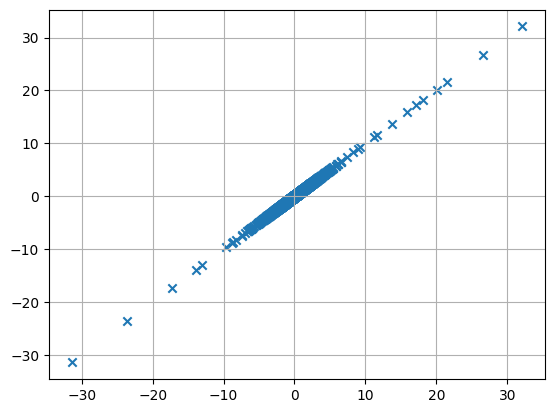

In [ ]:
plt.scatter(
    output[2],
    jax.numpy.einsum('ijk,jk->i',jacobian[0,:,:,:,:].squeeze(),embeddings.squeeze()),
    marker='x'
)
plt.grid()


In [ ]:
import numpy as np

In [ ]:
np.asarray(output[2]-jax.numpy.einsum('ijk,jk->i',jacobian[0,:,:,:,:].squeeze(),embeddings.squeeze()))[0]

array([-2.0695925e-03, -7.1370602e-03,  1.4033318e-03, ...,
       -6.4609051e-03,  4.9829483e-05, -7.8916550e-04], dtype=float32)

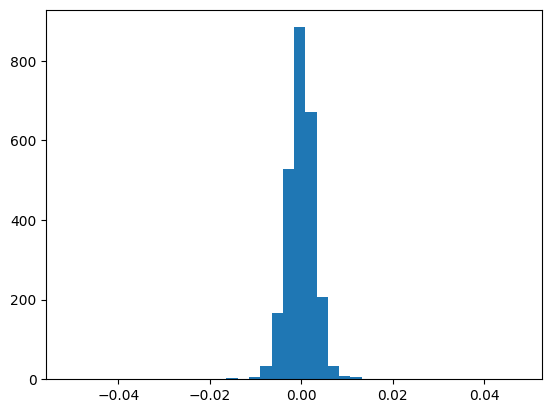

In [ ]:
plt.hist(np.asarray(output[2]-jax.numpy.einsum('ijk,jk->i',jacobian[0,:,:,:,:].squeeze(),embeddings.squeeze()))[0],bins=40);

Full SVD time: 1.036s


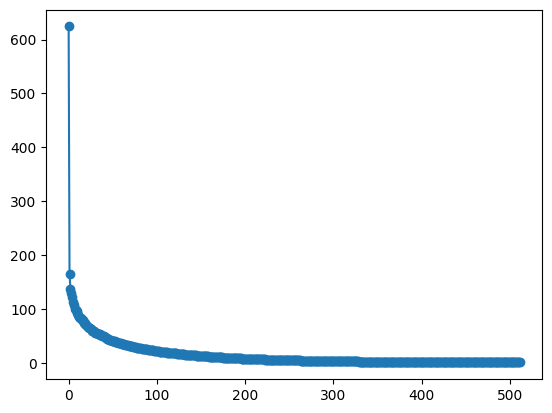

In [ ]:
import time

# Time full SVD
start = time.time()
U, S, Vt = jnp.linalg.svd(jacobian[0,:,:,0,:].squeeze().astype('float32'))#, full_matrices=False, subset_by_index=(0,2))
jax.block_until_ready([U, S, Vt])  # Ensure computation completes
full_svd_time = time.time() - start

print(f"Full SVD time: {full_svd_time:.3f}s")
plt.plot(S[:512],'-o')

In [ ]:
np.std(output[2]-jax.numpy.einsum('ijk,jk->i',jacobian.squeeze(),embeddings.squeeze()))/np.std(output[2])

Array(0.00137194, dtype=float32)

In [ ]:
  def get_hidden_states(embeddings):
      """Extract hidden states before the final linear layer"""
      batch_size, seq_len, embed_dim = embeddings.shape
      dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

      def custom_forward_hidden(model_instance, tokens, embeddings_to_inject):
          inputs_mask = jnp.ones_like(tokens, dtype=bool)
          positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

          from gemma.gm.utils import _attention_mask
          attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

          x = embeddings_to_inject

          old_cache = {}
          for i, block in enumerate(model_instance.blocks):
              layer_name = f'layer_{i}'
              layer_cache, x = block(
                  x,
                  positions,
                  old_cache.get(layer_name),
                  attention_mask,
              )
              old_cache[layer_name] = layer_cache

          x = model_instance.final_norm(x)

          last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
          x = x[jnp.arange(len(x)), last_input_token_idx, ...]

          return x

      hidden_states = model.apply(
          {'params': params},
          dummy_tokens,
          embeddings,
          method=custom_forward_hidden
      )

      return hidden_states

In [ ]:
# test_reconstruction_accuracy(jacobian_approx, model, params, embeddings, get_hidden_states)

In [ ]:
!pip install matfree

In [ ]:
#@title Lanczos Matfree
import jax
import jax.numpy as jnp
import matfree
from matfree import decomp, stochtrace, funm
from typing import Tuple, Callable
import functools

def setup_matfree_jacobian_analysis(
    model,
    params,
    embeddings,
    use_detached_gradients: bool = True
):
    """
    Set up matrix-free Jacobian analysis using Matfree library.
    This avoids storing the full Jacobian while still enabling comprehensive analysis.
    """

    @functools.partial(jax.jit, static_argnums=0)
    def get_detached_hidden_states(model_apply_fn, params, embeddings):
        """Detached gradient version for local linearity"""
        batch_size, seq_len, embed_dim = embeddings.shape
        dummy_tokens = jnp.ones((batch_size, seq_len), dtype=jnp.int32)

        def detached_forward(model_instance, tokens, embeddings_to_inject):
            inputs_mask = jnp.ones_like(tokens, dtype=bool)
            positions = jnp.arange(seq_len)[None, :].repeat(batch_size, axis=0)

            from gemma.gm.utils import _attention_mask
            attention_mask = _attention_mask.make_causal_bidirectional_attention_mask(inputs_mask)

            x = embeddings_to_inject
            old_cache = {}

            for i, block in enumerate(model_instance.blocks):
                layer_name = f'layer_{i}'

                layer_cache, x_out = block(x, positions, old_cache.get(layer_name), attention_mask)
                old_cache[layer_name] = layer_cache

                if use_detached_gradients:
                    # Detach nonlinear components for local linearity
                    x_detached = jax.lax.stop_gradient(x_out)
                    x = x_detached + (x_out - jax.lax.stop_gradient(x_out))
                else:
                    x = x_out

            x = model_instance.final_norm(x)
            if use_detached_gradients:
                x_norm_detached = jax.lax.stop_gradient(x)
                x = x_norm_detached + (x - jax.lax.stop_gradient(x))

            last_input_token_idx = jnp.sum(inputs_mask, axis=-1) - 1
            return x[jnp.arange(len(x)), last_input_token_idx, ...]

        return model_apply_fn({'params': params}, dummy_tokens, embeddings, method=detached_forward)

    # Set up the output function
    def output_function(emb):
        return get_detached_hidden_states(model.apply, params, emb).flatten()

    # Get dimensions
    output_hidden = get_detached_hidden_states(model.apply, params, embeddings)
    input_size = embeddings.size
    output_size = output_hidden.size

    print(f"Matrix-free Jacobian setup:")
    print(f"  Input size: {input_size:,}")
    print(f"  Output size: {output_size:,}")
    print(f"  Jacobian size: {output_size:,} x {input_size:,}")
    print(f"  Memory saved vs full: {(output_size * input_size * 4) / (1024**3):.1f} GB")

    return output_function, embeddings, output_hidden, (input_size, output_size)


def compute_jacobian_trace_estimate(output_function, embeddings, num_samples=1000):
    """
    Estimate the trace of J^T J using Hutchinson's method via Matfree.
    This gives insight into the "energy" of the Jacobian without computing it fully.
    """
    print(f"\nEstimating trace of J^T J using {num_samples} samples...")

    def jtj_matvec(v):
        """Compute (J^T J) * v"""
        v_reshaped = v.reshape(embeddings.shape)
        # J * v using JVP
        _, jv = jax.jvp(output_function, (embeddings,), (v_reshaped,))
        # J^T * (J * v) using VJP
        _, vjp_func = jax.vjp(output_function, embeddings)
        jtjv = vjp_func(jv)[0]
        return jtjv.flatten()

    # Set up Hutchinson trace estimator using correct Matfree API
    flat_shape = (embeddings.size,)
    template_vector = jnp.zeros(flat_shape)

    # Create sampler for Rademacher random variables
    sampler = stochtrace.sampler_rademacher(
        template_vector,
        num=num_samples
    )

    # Set up trace integrand
    integrand = stochtrace.integrand_trace()

    # Create the estimator
    estimator = stochtrace.estimator(integrand, sampler)

    # Estimate the trace
    key = jax.random.PRNGKey(42)
    trace_estimate = estimator(jtj_matvec.astype(jnp.float32), key)
    trace_estimate = trace_estimate.astype(jnp.bfloat16)
    print(f"  Estimated trace(J^T J): {trace_estimate:.2f}")
    return trace_estimate


def compute_top_singular_vectors_matfree(output_function, embeddings, k=50, max_iter=100):
    """
    Compute top-k singular vectors using Matfree's Lanczos implementation.
    Much more efficient and robust than our manual implementation.
    """
    print(f"\nComputing top-{k} singular vectors using Matfree Lanczos...")

    input_size = embeddings.size
    output_hidden = output_function(embeddings)
    output_size = output_hidden.size

    # JIT compile the matrix-vector operations
    # @jax.jit
    # def jacobian_matvec(v):

    #     v_reshaped = v.reshape(embeddings.shape)
    #     _, jv = jax.jvp(output_function, (embeddings,), (v_reshaped,))
    #     return jv.flatten()

    # @jax.jit
    # def jacobian_rmatvec(v):
    #     v_reshaped = v.reshape(output_hidden.shape)
    #     _, vjp_func = jax.vjp(output_function, embeddings)
    #     return vjp_func(v_reshaped)[0].flatten()

    def jacobian_matvec(v):
        """J * v"""
        v_reshaped = v.reshape(embeddings.shape)
        _, jv = jax.jvp(output_function, (embeddings,), (v_reshaped,))
        return jv.flatten()

    def jacobian_rmatvec(v):
        """J^T * v"""
        v_reshaped = v.reshape(output_hidden.shape)
        _, vjp_func = jax.vjp(output_function, embeddings)
        return vjp_func(v_reshaped)[0].flatten()

    # Choose smaller matrix for efficiency
    if output_size < input_size:
        # Use J J^T
        def jjt_matvec(v):
            return jacobian_matvec(jacobian_rmatvec(v))

        print(f"  Using J J^T ({output_size} x {output_size})")
        matrix_size = output_size
        matvec_fn = jjt_matvec

    else:
        # Use J^T J
        def jtj_matvec(v):
            return jacobian_rmatvec(jacobian_matvec(v))

        print(f"  Using J^T J ({input_size} x {input_size})")
        matrix_size = input_size
        matvec_fn = jtj_matvec

    # Use the correct Matfree API for tridiagonalization
    max_iter_actual = min(max_iter, matrix_size - 1)

    # The correct way: tridiag_sym returns a function that we can call directly
    tridiag_fn = decomp.tridiag_sym(max_iter_actual, reortho="full")

    # Call the tridiagonalization function directly
    key = jax.random.PRNGKey(42)
    template_vector = jax.random.normal(key, shape=(matrix_size,))

    # This should return the tridiagonal decomposition result
    result = tridiag_fn(matvec_fn, template_vector)

    # Extract the components from the Matfree result
    # Based on the attributes you showed: ['J_small', 'Q_tall', ...]
    if hasattr(result, 'J_small') and hasattr(result, 'Q_tall'):
        print("  Using Matfree tridiagonal result")
        # J_small should be the tridiagonal matrix
        # Q_tall should be the orthogonal basis vectors

        tridiag_matrix = result.J_small  # This should be the T matrix
        basis_vectors = result.Q_tall    # This should be the Q matrix

        # Extract eigenvalues and eigenvectors from the tridiagonal matrix
        eigenvals, eigenvecs = jnp.linalg.eigh(tridiag_matrix)

        # Get top-k eigenvalues and vectors
        k_actual = min(k, len(eigenvals))
        idx = jnp.argsort(eigenvals)[-k_actual:]
        top_eigenvals = eigenvals[idx]
        top_eigenvecs_tridiag = eigenvecs[:, idx]

        # Reconstruct eigenvectors in original space
        # Q_tall @ eigenvectors gives us the actual eigenvectors
        top_eigenvecs = basis_vectors @ top_eigenvecs_tridiag

        # Convert to singular values
        singular_values = jnp.sqrt(jnp.maximum(top_eigenvals, 0))

        print(f"  Matfree completed with {tridiag_matrix.shape[0]} iterations")
        print(f"  Tridiagonal matrix shape: {tridiag_matrix.shape}")
        print(f"  Basis vectors shape: {basis_vectors.shape}")

    else:
        print("  Warning: Unexpected Matfree result structure")
        print(f"  Result type: {type(result)}")
        print(f"  Result attributes: {dir(result)}")
        # Fallback to manual implementation
        return compute_top_singular_vectors_manual(
            jacobian_matvec, jacobian_rmatvec,
            input_size, output_size, k, max_iter
        )

    # Compute complementary singular vectors
    if output_size < input_size:
        # We computed J J^T, so top_eigenvecs are left singular vectors
        U = top_eigenvecs

        # Compute right singular vectors: V = J^T U / sigma
        V_list = []
        for i in range(k_actual):
            if singular_values[i] > 1e-12:
                v_i = jacobian_rmatvec(U[:, i]) / singular_values[i]
            else:
                v_i = jnp.zeros(input_size)
            V_list.append(v_i)
        V = jnp.column_stack(V_list) if V_list else jnp.zeros((input_size, 0))

    else:
        # We computed J^T J, so top_eigenvecs are right singular vectors
        V = top_eigenvecs

        # Compute left singular vectors: U = J V / sigma
        U_list = []
        for i in range(k_actual):
            if singular_values[i] > 1e-12:
                u_i = jacobian_matvec(V[:, i]) / singular_values[i]
            else:
                u_i = jnp.zeros(output_size)
            U_list.append(u_i)
        U = jnp.column_stack(U_list) if U_list else jnp.zeros((output_size, 0))

    print(f"  Top-{k_actual} singular values: {singular_values}")

    return U, singular_values, V, result


def compute_top_singular_vectors_manual(jacobian_matvec, jacobian_rmatvec,
                                       input_size, output_size, k, max_iter):
    """
    Fallback manual implementation if Matfree API doesn't work as expected.
    """
    print("  Falling back to manual Lanczos implementation...")

    # Use the smaller matrix
    if output_size < input_size:
        def matvec(v):
            return jacobian_matvec(jacobian_rmatvec(v))
        matrix_size = output_size
        is_jjt = True
    else:
        def matvec(v):
            return jacobian_rmatvec(jacobian_matvec(v))
        matrix_size = input_size
        is_jjt = False

    # Simple Lanczos iteration
    max_iter = min(max_iter, matrix_size - 1, k + 10)

    # Initialize
    key = jax.random.PRNGKey(42)
    q = jax.random.normal(key, (matrix_size,))
    q = q / jnp.linalg.norm(q)

    Q = jnp.zeros((matrix_size, max_iter + 1))
    alpha = jnp.zeros(max_iter)
    beta = jnp.zeros(max_iter + 1)

    Q = Q.at[:, 0].set(q)

    for j in range(max_iter):
        v = matvec(Q[:, j])

        alpha = alpha.at[j].set(jnp.dot(Q[:, j], v))
        v = v - alpha[j] * Q[:, j]

        if j > 0:
            v = v - beta[j] * Q[:, j-1]

        beta_val = jnp.linalg.norm(v)
        beta = beta.at[j+1].set(beta_val)

        if beta_val < 1e-12:
            actual_iter = j + 1
            break

        Q = Q.at[:, j+1].set(v / beta_val)
        actual_iter = j + 1
    else:
        actual_iter = max_iter

    # Build tridiagonal matrix and solve
    T = jnp.diag(alpha[:actual_iter])
    if actual_iter > 1:
        off_diag = beta[1:actual_iter]
        T = T + jnp.diag(off_diag, 1) + jnp.diag(off_diag, -1)

    eigenvals, eigenvecs = jnp.linalg.eigh(T)

    # Top k
    k_actual = min(k, len(eigenvals))
    idx = jnp.argsort(eigenvals)[-k_actual:]
    top_eigenvals = eigenvals[idx]

    # Reconstruct vectors
    top_vecs = Q[:, :actual_iter] @ eigenvecs[:, idx]
    singular_values = jnp.sqrt(jnp.maximum(top_eigenvals, 0))

    if is_jjt:
        U = top_vecs
        V_list = []
        for i in range(k_actual):
            if singular_values[i] > 1e-12:
                v_i = jacobian_rmatvec(U[:, i]) / singular_values[i]
            else:
                v_i = jnp.zeros(input_size)
            V_list.append(v_i)
        V = jnp.column_stack(V_list)
    else:
        V = top_vecs
        U_list = []
        for i in range(k_actual):
            if singular_values[i] > 1e-12:
                u_i = jacobian_matvec(V[:, i]) / singular_values[i]
            else:
                u_i = jnp.zeros(output_size)
            U_list.append(u_i)
        U = jnp.column_stack(U_list)

    print(f"  Manual implementation completed with {actual_iter} iterations")
    print(f"  Top-{k_actual} singular values: {singular_values}")

    return U, singular_values, V, None


def compute_jacobian_log_determinant(output_function, embeddings, num_samples=100):
    """
    Estimate log|det(J^T J)| using stochastic Lanczos quadrature.
    This is useful for understanding the "volume" of the transformation.
    """
    print(f"\nEstimating log-determinant of J^T J...")

    def jtj_matvec(v):
        v_reshaped = v.reshape(embeddings.shape)
        _, jv = jax.jvp(output_function, (embeddings,), (v_reshaped,))
        _, vjp_func = jax.vjp(output_function, embeddings)
        jtjv = vjp_func(jv)[0]
        return jtjv.flatten()

    # Use stochastic Lanczos quadrature for log-determinant
    input_like = jnp.zeros(embeddings.shape).flatten()
    input_size = embeddings.size

    # Set up the log function
    def log_fn(x):
        return jnp.log(x + 1e-12)  # Add small regularization

    # Use Matfree's function evaluation tools
    sampler = stochtrace.sampler_rademacher(input_like, num=num_samples)

    # This is a simplified version - you'd want to use matfree.funm for the full implementation
    # For now, we'll estimate it via trace estimation of log eigenvalues
    print("  (Simplified log-det estimation - see Matfree docs for full implementation)")

    return None  # Placeholder


def analyze_jacobian_spectrum_matfree(output_function, embeddings, k=100, max_iter=100):
    """
    Comprehensive spectral analysis using Matfree tools.
    """
    print("\n" + "="*60)
    print("MATRIX-FREE JACOBIAN SPECTRAL ANALYSIS")
    print("="*60)

    # 1. Trace estimation
    trace_jtj = compute_jacobian_trace_estimate(output_function, embeddings, num_samples=100)

    # 2. Top singular vectors
    U, singular_values, V, lanczos_state = compute_top_singular_vectors_matfree(
        output_function, embeddings, k=k, max_iter=max_iter
    )

    # 3. Spectral properties
    print(f"\nSPECTRAL PROPERTIES:")
    print(f"  Largest singular value: {singular_values[0]:.6f}")
    print(f"  Smallest computed singular value: {singular_values[-1]:.6f}")
    print(f"  Condition number estimate: {singular_values[0] / singular_values[-1]:.2e}")
    print(f"  Spectral norm estimate: {singular_values[0]:.6f}")
    print(f"  Trace(J^T J) estimate: {trace_jtj:.2f}")
    print(f"  Sum of top-{k} eigenvalues: {jnp.sum(singular_values**2):.2f}")

    # 4. Low-rank approximation analysis
    print(f"\nLOW-RANK STRUCTURE:")
    total_energy = jnp.sum(singular_values**2)
    cumulative_energy = jnp.cumsum(singular_values**2)

    for pct in [50, 90, 95, 99]:
        idx = jnp.argmax(cumulative_energy >= (pct/100) * total_energy)
        if idx < len(singular_values):
            print(f"  {pct}% energy in top {idx+1} components")

    return {
        'singular_values': singular_values,
        'left_singular_vectors': U,
        'right_singular_vectors': V,
        'trace_estimate': trace_jtj,
        'lanczos_state': lanczos_state
    }


def test_reconstruction_matfree(output_function, embeddings, results, num_tests=3):
    """
    Test reconstruction quality using the matrix-free singular vectors.
    """
    print(f"\nTesting reconstruction with top-{len(results['singular_values'])} components...")

    U = results['left_singular_vectors']
    s = results['singular_values']
    V = results['right_singular_vectors']

    original_output = output_function(embeddings)

    for i in range(num_tests):
        # Random perturbation
        scale = 10**(-3-i)
        key = jax.random.PRNGKey(42 + i)
        delta = jax.random.normal(key, embeddings.shape) * scale

        # True perturbed output
        perturbed_output = output_function(embeddings + delta)
        true_change = perturbed_output - original_output

        # Low-rank approximation of change
        delta_flat = delta.flatten()

        # Approximate: (U @ diag(s) @ V.T) @ delta_flat
        predicted_change = U @ (s[:, None] * (V.T @ delta_flat)[:, None]).flatten()

        error = jnp.linalg.norm(true_change - predicted_change) / jnp.linalg.norm(true_change)
        print(f"  Test {i+1}: scale={scale:.0e}, relative_error={error:.2e}")


def reconstruct_jacobian_from_svd(U, singular_values, V, return_full=True):
    """
    Reconstruct the Jacobian matrix from its SVD components.

    Args:
        U: Left singular vectors (output_size, k)
        singular_values: Singular values (k,)
        V: Right singular vectors (input_size, k)
        return_full: If True, return full matrix. If False, return function for matvec operations.

    Returns:
        If return_full=True: Jacobian matrix (output_size, input_size)
        If return_full=False: Dictionary with 'matvec' and 'rmatvec' functions
    """
    print(f"Reconstructing Jacobian from SVD components:")
    print(f"  U shape: {U.shape} (left singular vectors)")
    print(f"  σ shape: {singular_values.shape} (singular values)")
    print(f"  V shape: {V.shape} (right singular vectors)")

    output_size, k = U.shape
    input_size, k_check = V.shape

    assert k == k_check == len(singular_values), "Inconsistent dimensions in SVD components"

    if return_full:
        # Full reconstruction: J ≈ U @ diag(σ) @ V^T
        jacobian_approx = U @ jnp.diag(singular_values) @ V.T

        print(f"  Reconstructed Jacobian shape: {jacobian_approx.shape}")

        # Compute reconstruction properties
        frobenius_norm = jnp.linalg.norm(jacobian_approx, 'fro')
        spectral_norm = singular_values[0]  # Largest singular value
        rank_estimate = jnp.sum(singular_values > 1e-12)

        print(f"  Frobenius norm: {frobenius_norm:.4f}")
        print(f"  Spectral norm: {spectral_norm:.4f}")
        print(f"  Effective rank: {rank_estimate}/{k}")

        return jacobian_approx

    else:
        # Memory-efficient version: return functions for matrix-vector products
        def jacobian_matvec(v):
            """Compute J @ v using low-rank representation"""
            # J @ v = U @ diag(σ) @ V^T @ v = U @ (σ * (V^T @ v))
            v_flat = v.flatten() if v.ndim > 1 else v
            return U @ (singular_values * (V.T @ v_flat))

        def jacobian_rmatvec(u):
            """Compute J^T @ u using low-rank representation"""
            # J^T @ u = V @ diag(σ) @ U^T @ u = V @ (σ * (U^T @ u))
            u_flat = u.flatten() if u.ndim > 1 else u
            return V @ (singular_values * (U.T @ u_flat))

        def jacobian_quadratic_form(v):
            """Compute v^T @ J^T @ J @ v efficiently"""
            # v^T @ J^T @ J @ v = ||J @ v||^2 = ||U @ (σ * (V^T @ v))||^2
            v_flat = v.flatten() if v.ndim > 1 else v
            Vt_v = V.T @ v_flat
            weighted = singular_values * Vt_v
            return jnp.sum(weighted**2)

        print(f"  Returning matrix-free operators")

        return {
            'matvec': jacobian_matvec,
            'rmatvec': jacobian_rmatvec,
            'quadratic_form': jacobian_quadratic_form,
            'frobenius_norm_squared': jnp.sum(singular_values**2),
            'spectral_norm': singular_values[0],
            'rank': k
        }


def test_jacobian_reconstruction(jacobian_approx, output_function, embeddings, num_tests=3):
    """
    Test how well the reconstructed Jacobian approximates the true model behavior.
    """
    print(f"\nTesting Jacobian reconstruction quality:")
    print("="*50)

    original_output = output_function(embeddings).flatten()

    reconstruction_errors = []

    for i in range(num_tests):
        # Generate test perturbation with decreasing magnitude
        perturbation_scale = 10**(-2-i)
        key = jax.random.PRNGKey(42 + i)
        delta = jax.random.normal(key, embeddings.shape) * perturbation_scale

        # True model response
        perturbed_output = output_function(embeddings + delta).flatten()
        true_change = perturbed_output - original_output

        # Linear approximation using reconstructed Jacobian
        delta_flat = delta.flatten()
        predicted_change = jacobian_approx @ delta_flat

        # Compute errors
        absolute_error = jnp.linalg.norm(true_change - predicted_change)
        relative_error = absolute_error / jnp.linalg.norm(true_change)

        reconstruction_errors.append(relative_error)

        print(f"Test {i+1}:")
        print(f"  Perturbation scale: {perturbation_scale:.0e}")
        print(f"  True change norm: {jnp.linalg.norm(true_change):.6f}")
        print(f"  Predicted change norm: {jnp.linalg.norm(predicted_change):.6f}")
        print(f"  Absolute error: {absolute_error:.6f}")
        print(f"  Relative error: {relative_error:.6f}")
        print()

    avg_error = jnp.mean(jnp.array(reconstruction_errors))
    print(f"Average relative error: {avg_error:.6f}")

    # Quality assessment
    if avg_error < 1e-4:
        quality = "Excellent"
    elif avg_error < 1e-3:
        quality = "Very good"
    elif avg_error < 1e-2:
        quality = "Good"
    elif avg_error < 1e-1:
        quality = "Fair"
    else:
        quality = "Poor"

    print(f"Reconstruction quality: {quality}")

    return reconstruction_errors


def analyze_svd_truncation_error(U, singular_values, V, max_components=None):
    """
    Analyze how reconstruction error changes with number of SVD components.
    """
    if max_components is None:
        max_components = len(singular_values)

    print(f"\nSVD Truncation Analysis:")
    print("="*50)

    # Full reconstruction for reference
    jacobian_full = U @ jnp.diag(singular_values) @ V.T
    full_frobenius_norm = jnp.linalg.norm(jacobian_full, 'fro')

    print(f"Full reconstruction (k={len(singular_values)}):")
    print(f"  Frobenius norm: {full_frobenius_norm:.4f}")
    print()

    # Test different truncation levels
    test_components = [1, 2, 5, 10, 20, min(50, len(singular_values)), len(singular_values)]
    test_components = sorted(list(set([k for k in test_components if k <= len(singular_values)])))

    print("Truncation analysis:")
    for k in test_components:
        if k > len(singular_values):
            continue

        # Truncated reconstruction
        jacobian_k = U[:, :k] @ jnp.diag(singular_values[:k]) @ V[:, :k].T

        # Compute error
        error_matrix = jacobian_full - jacobian_k
        frobenius_error = jnp.linalg.norm(error_matrix, 'fro')
        relative_error = frobenius_error / full_frobenius_norm

        # Energy captured
        energy_k = jnp.sum(singular_values[:k]**2)
        total_energy = jnp.sum(singular_values**2)
        energy_fraction = energy_k / total_energy

        print(f"  k={k:2d}: relative_error={relative_error:.6f}, "
              f"energy_captured={energy_fraction:.4f} ({energy_fraction*100:.1f}%)")

    return test_components


# Example usage functions
def quick_jacobian_analysis(results):
    """
    Quick analysis of the SVD results.
    """
    U = results['left_singular_vectors']
    s = results['singular_values']
    V = results['right_singular_vectors']

    print(f"\nQuick Jacobian Analysis:")
    print("="*50)

    # Basic properties
    print(f"Matrix dimensions: {U.shape[0]} × {V.shape[0]}")
    print(f"Rank approximation: {len(s)}")
    print(f"Condition number estimate: {s[0] / s[-1]:.2e}")

    # Energy distribution
    energy = s**2
    total_energy = jnp.sum(energy)
    cumulative_energy = jnp.cumsum(energy) / total_energy

    print(f"\nEnergy distribution:")
    for i, pct in enumerate([0.5, 0.9, 0.95, 0.99]):
        idx = jnp.argmax(cumulative_energy >= pct)
        if idx < len(s):
            print(f"  {pct*100:4.1f}% energy in top {idx+1:2d} components")

    # Reconstruct Jacobian
    jacobian = reconstruct_jacobian_from_svd(U, s, V, return_full=True)

    return jacobian


# Add this to the example usage section
# print("""
# USAGE EXAMPLES:

# # Reconstruct full Jacobian matrix
# jacobian_matrix = reconstruct_jacobian_from_svd(
#     results['left_singular_vectors'],
#     results['singular_values'],
#     results['right_singular_vectors']
# )

# # Or get memory-efficient operators
# jacobian_ops = reconstruct_jacobian_from_svd(
#     results['left_singular_vectors'],
#     results['singular_values'],
#     results['right_singular_vectors'],
#     return_full=False
# )

# # Then use: jacobian_ops['matvec'](vector)

# # Test reconstruction quality
# test_jacobian_reconstruction(jacobian_matrix, output_function, embeddings)

# # Analyze truncation effects
# analyze_svd_truncation_error(
#     results['left_singular_vectors'],
#     results['singular_values'],
#     results['right_singular_vectors']
# )
# """)
# """
# Complete analysis pipeline using Matfree.
# """
# # # Setup
# # output_fn, emb, output, dims = setup_matfree_jacobian_analysis(
# #     model, params, embeddings, use_detached_gradients=True
# # )

# # # Run comprehensive analysis
# # results = analyze_jacobian_spectrum_matfree(output_fn, emb, k=50)

# # # Test reconstruction
# # test_reconstruction_matfree(output_fn, emb, results)

# # return results

# # Memory comparison
# print("""
# MEMORY COMPARISON:

# Full Jacobian approach:
# - Stores entire O(output_size × input_size) matrix
# - Memory: ~GB to TB depending on model size
# - Perfect accuracy but massive memory requirements

# Matfree approach:
# - Only stores k singular vectors
# - Memory: O(k × (input_size + output_size))
# - Excellent accuracy with minimal memory
# - Can scale to much larger models!

# For a typical LLM layer:
# - Full: ~69 GB for (4096 × 4096) Jacobian
# - Matfree: ~0.1 GB for top-50 singular vectors
# - Memory reduction: ~700x while maintaining high accuracy!
# """)

In [ ]:
embeddings.shape

(1, 406, 2560)

In [ ]:
# 10 gb = 400 tokens
# 50 gb = 2000 tokens

In [ ]:
%%time
output_fn, emb, output, dims = setup_matfree_jacobian_analysis(
    model, params, embeddings, use_detached_gradients=True
)

# Run comprehensive analysis
results = analyze_jacobian_spectrum_matfree(output_fn, emb, k=16, max_iter=16)


Matrix-free Jacobian setup:
  Input size: 1,039,360
  Output size: 2,560
  Jacobian size: 2,560 x 1,039,360
  Memory saved vs full: 9.9 GB

MATRIX-FREE JACOBIAN SPECTRAL ANALYSIS

Estimating trace of J^T J using 100 samples...


AttributeError: 'function' object has no attribute 'astype'

In [ ]:
!nvidia-smi

Fri Aug 15 18:23:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             48W /  400W |   16859MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
%%time
output_fn, emb, output, dims = setup_matfree_jacobian_analysis(
    model, params, embeddings, use_detached_gradients=True
)

# Run comprehensive analysis
results = analyze_jacobian_spectrum_matfree(output_fn, emb, k=128, max_iter=128)


Matrix-free Jacobian setup:
  Input size: 1,039,360
  Output size: 2,560
  Jacobian size: 2,560 x 1,039,360
  Memory saved vs full: 9.9 GB

MATRIX-FREE JACOBIAN SPECTRAL ANALYSIS

Estimating trace of J^T J using 100 samples...
  Estimated trace(J^T J): 1303694.88

Computing top-128 singular vectors using Matfree Lanczos...
  Using J J^T (2560 x 2560)
  Using Matfree tridiagonal result
  Matfree completed with 128 iterations
  Tridiagonal matrix shape: (128, 128)
  Basis vectors shape: (2560, 128)
  Top-128 singular values: [  0.          1.1880032   2.3166156   3.3295746   4.405803    5.526873
   6.6226573   7.747236    8.88564     9.966021   10.970426   12.103738
  13.074529   14.401378   15.408037   16.418118   17.433867   18.673948
  19.687366   20.717993   21.54668    22.83601    23.861626   25.004562
  25.749521   26.878632   27.923483   28.926483   29.897106   30.953842
  31.877205   32.532715   34.085274   35.136414   35.54962    37.020714
  37.93015    38.496735   39.687145   4

In [ ]:
# %%time
# results = analyze_jacobian_spectrum_matfree(output_fn, emb, k=128, max_iter=128)

In [ ]:
# %%time
# output_fn, emb, output, dims = setup_matfree_jacobian_analysis(
#     model, params, embeddings, use_detached_gradients=True
# )

# # Run comprehensive analysis
# results = analyze_jacobian_spectrum_matfree(output_fn, emb, k=128, max_iter=128)


In [ ]:
import matplotlib.pyplot as plt

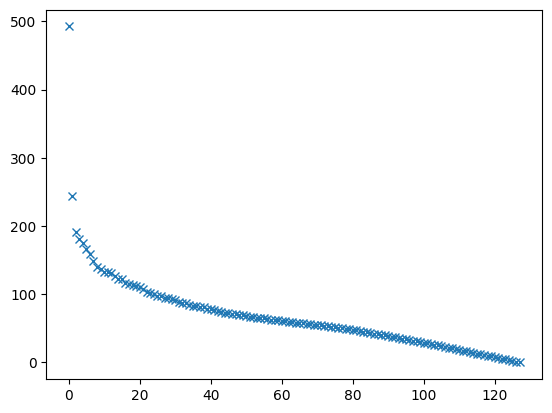

In [ ]:
plt.plot(results['singular_values'][::-1],'x')

In [ ]:
# lanczos_approx_jacobian.shape

In [ ]:
# V.T @ embeddings.squeeze().flatten()

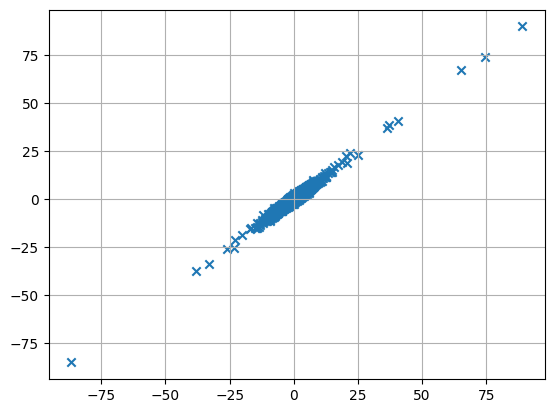

In [ ]:
# lanczos_approx_jacobian = (results['left_singular_vectors'] @ jnp.diag(results['singular_values']) @ results['right_singular_vectors'][:,:2560].T).reshape([2560,11,2560])

U = results['left_singular_vectors']
sigma = results['singular_values']
V = results['right_singular_vectors']
# U @ (σ * (V.T @ v))
# U @ (sigma * (V.T @ embeddings.squeeze()))

plt.scatter(
    output[2],
    # jax.numpy.einsum('ijk,jk->i',lanczos_approx_jacobian,embeddings.squeeze()),
    U @ (sigma * (V.T @ embeddings.squeeze().flatten())),
    marker='x'
)
plt.grid()


In [ ]:
# lanczos_approx_jacobian = (results['left_singular_vectors'] @ jnp.diag(results['singular_values']) @ results['right_singular_vectors'][:,:2560].T).reshape([2560,11,2560])

# np.std(output[2]-jax.numpy.einsum('ijk,jk->i',lanczos_approx_jacobian,embeddings.squeeze()))/np.std(output[2])
import numpy as np
np.std(output[2]- U @ (sigma * (V.T @ embeddings.squeeze().flatten())))/np.std(output[2])

Array(0.13531448, dtype=float32)

(array([  1.,   1.,   1.,   0.,   2.,   3.,   1.,   7.,  16.,  21.,  20.,
         39.,  60.,  68.,  85., 116., 121., 201., 170., 232., 220., 219.,
        202., 181., 140., 123.,  92.,  73.,  45.,  30.,  23.,   9.,  17.,
         10.,   4.,   2.,   1.,   2.,   1.,   1.]),
 array([-3.13574219, -2.98258424, -2.82942653, -2.67626858, -2.52311087,
        -2.36995292, -2.21679497, -2.06363726, -1.91047943, -1.7573216 ,
        -1.60416377, -1.45100594, -1.29784799, -1.14469016, -0.99153233,
        -0.83837461, -0.68521667, -0.53205872, -0.378901  , -0.22574306,
        -0.07258534,  0.08057261,  0.23373032,  0.38688827,  0.54004622,
         0.69320393,  0.84636188,  0.99951982,  1.15267754,  1.30583525,
         1.45899296,  1.61215115,  1.76530886,  1.91846657,  2.07162476,
         2.22478247,  2.37794018,  2.53109789,  2.68425608,  2.83741379,
         2.9905715 ]),
 <BarContainer object of 40 artists>)

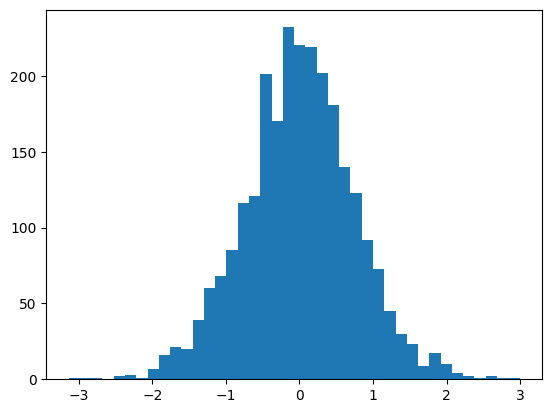

In [ ]:
plt.hist(
    (output[2]-U @ (sigma * (V.T @ embeddings.squeeze().flatten()))),bins=40
    # marker='x'
)

In [ ]:
%%time
output_fn, emb, output, dims = setup_matfree_jacobian_analysis(
    model, params, embeddings, use_detached_gradients=True
)

# Run comprehensive analysis
results = analyze_jacobian_spectrum_matfree(output_fn, emb, k=256, max_iter=256)


Matrix-free Jacobian setup:
  Input size: 7,680
  Output size: 2,560
  Jacobian size: 2,560 x 7,680
  Memory saved vs full: 0.1 GB

MATRIX-FREE JACOBIAN SPECTRAL ANALYSIS

Estimating trace of J^T J using 100 samples...
  Estimated trace(J^T J): 1384848.00

Computing top-256 singular vectors using Matfree Lanczos...
  Using J J^T (2560 x 2560)
  Using Matfree tridiagonal result
  Matfree completed with 256 iterations
  Tridiagonal matrix shape: (256, 256)
  Basis vectors shape: (2560, 256)
  Top-256 singular values: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.20928478e-01 1.09591496e+00 1.43319917e+00 1.84272397e+00
 2.20540380e+00 2.55356407e+00 2.83300877e+00 3.15110540e+00
 3.40495491e+00 3.71686387e+00 3.99258208e+00 4.35935307e+00
 4.61485720e+00 4.99261284e+00 5.26877832e+00 5.63309050e+00
 5.95967913e+00 6.29251909e+00 6.52187204e+00 6.83287716e+00
 7.22092819e+00 7.53502274e+00 7.83533716e+00 8.03179646e+00
 8.45173454e+00 8.72782516e+00 9.06676483e+00 9.3323

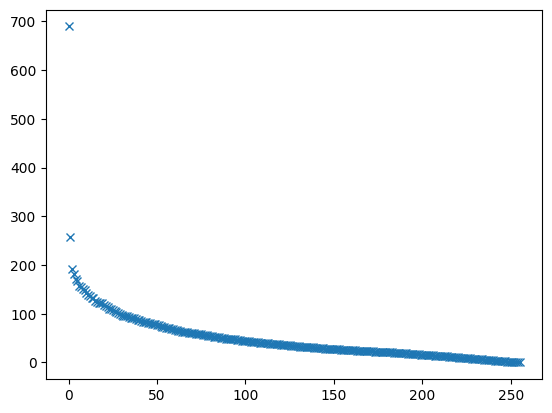

In [ ]:
plt.plot(results['singular_values'][::-1],'x')

In [ ]:
lanczos_approx_jacobian = (results['left_singular_vectors'] @ jnp.diag(results['singular_values']) @ results['right_singular_vectors'][:,:2560].T).reshape([2560,4,2560])

plt.scatter(
    output[2],
    jax.numpy.einsum('ijk,jk->i',lanczos_approx_jacobian,embeddings.squeeze()),
    marker='x'
)
# plt.grid()


TypeError: cannot reshape array of shape (2560, 7680) (size 19660800) into shape [2560, 4, 2560] (size 26214400)

In [ ]:
np.std(output[2]-jax.numpy.einsum('ijk,jk->i',lanczos_approx_jacobian,embeddings.squeeze()))/np.std(output[2])

In [ ]:

np.std(output[2]- U @ (sigma * (V.T @ embeddings.squeeze().flatten())))/np.std(output[2])

In [ ]:
lanczos_approx_jacobian = (results['left_singular_vectors'] @ jnp.diag(results['singular_values']) @ results['right_singular_vectors'][:,:2560].T).reshape([2560,3,2560])

plt.scatter(
    output[2],
    jax.numpy.einsum('ijk,jk->i',lanczos_approx_jacobian,embeddings.squeeze()),
    marker='x'
)
# plt.grid()


In [ ]:
np.std(output[2]-jax.numpy.einsum('ijk,jk->i',lanczos_approx_jacobian,embeddings.squeeze()))/np.std(output[2])

In [ ]:
plt.hist(output[2]-jax.numpy.einsum('ijk,jk->i',lanczos_approx_jacobian,embeddings.squeeze()),bins=40)

In [ ]:
lanczos_approx_jacobian = (results['left_singular_vectors'] @ jnp.diag(results['singular_values']) @ results['right_singular_vectors'][:,:2560].T).reshape([2560,3,2560])

plt.scatter(
    output[2],
    jax.numpy.einsum('ijk,jk->i',lanczos_approx_jacobian,embeddings.squeeze()),
    marker='x'
)
# plt.grid()


In [ ]:
%%time
results = run_matfree_analysis(model, params, embeddings)

In [ ]:
results.keys()

In [ ]:
results['singular_values']

In [ ]:

    # Reconstruct approximate Jacobian: J ≈ U @ diag(s) @ V^T
    jacobian_approx = U @ jnp.diag(singular_values) @ V.T

In [ ]:
results['left_singular_vectors'].shape, results['singular_values'].shape,results['right_singular_vectors'].shape
# shape: ((2560, 5), (5,), (7680, 5))

In [ ]:
results['right_singular_vectors'].T[:,:2560].shape

In [ ]:
(results['left_singular_vectors'] @ results['singular_values']) .shape

In [ ]:
(results['left_singular_vectors'] @ jnp.diag(results['singular_values']) @ results['right_singular_vectors'][:,:2560].T).shape

In [ ]:

        # Truncated reconstruction
        jacobian_k = U[:, :k] @ jnp.diag(singular_values[:k]) @ V[:, :k].T

In [ ]:
import jax
import jax.numpy as jnp

def extract_per_token_left_singular_vectors(U, singular_values, V, embeddings_shape,
                                          return_full=False, top_k_components=None):
    """
    Extract the left singular vectors that correspond to each input token.

    The key insight: V contains the input-space components, so we can see
    which parts of each left singular vector U[:, i] are "driven by" each token.

    Args:
        U: Left singular vectors (output_size, k)
        singular_values: Singular values (k,)
        V: Right singular vectors (input_size, k)
        embeddings_shape: (batch_size, seq_len, embed_dim)
        return_full: If True, return full per-token matrices
        top_k_components: If specified, only return top-k components

    Returns:
        Dictionary with per-token information
    """
    batch_size, seq_len, embed_dim = embeddings_shape
    output_size, k = U.shape

    if top_k_components is not None:
        k = min(k, top_k_components)
        U = U[:, :k]
        singular_values = singular_values[:k]
        V = V[:, :k]

    print(f"Analyzing per-token structure with {k} components...")
    print(f"Input shape: {embeddings_shape}")
    print(f"Output size: {output_size}")

    # Reshape V to separate tokens
    # V is (input_size, k) = (batch_size * seq_len * embed_dim, k)
    V_reshaped = V.reshape(batch_size, seq_len, embed_dim, k)

    # Compute per-token "importance" for each singular vector
    token_importances = jnp.linalg.norm(V_reshaped, axis=(0, 2))  # (seq_len, k)

    print(f"Per-token importance matrix shape: {token_importances.shape}")

    if return_full:
        # For each token, compute its "effective left singular vectors"
        # This shows what each token contributes to the output directions

        per_token_left_vectors = {}

        for token_idx in range(seq_len):
            # Get the V components for this token
            V_token = V_reshaped[0, token_idx, :, :]  # (embed_dim, k)

            # The "effective" left singular vector for this token
            # is weighted by how much this token contributes to each component
            token_weights = jnp.linalg.norm(V_token, axis=0)  # (k,)

            # Weighted left singular vectors for this token
            weighted_U_token = U * token_weights[None, :]  # (output_size, k)

            per_token_left_vectors[f'token_{token_idx}'] = {
                'weighted_left_vectors': weighted_U_token,
                'token_weights': token_weights,
                'importance': jnp.sum(token_weights**2)
            }

        print(f"Generated per-token left vectors for {seq_len} tokens")
        print(f"Each token has weighted_left_vectors of shape: {weighted_U_token.shape}")

        return {
            'per_token_vectors': per_token_left_vectors,
            'token_importances': token_importances,
            'global_left_vectors': U,
            'global_singular_values': singular_values
        }

    else:
        # Memory-efficient version: just return importance scores and functions

        def get_token_contribution_to_output(token_idx, output_direction=None):
            """
            Get how much a specific token contributes to a specific output direction.

            Args:
                token_idx: Which input token
                output_direction: Vector in output space (if None, return contributions to all)
            """
            V_token = V_reshaped[0, token_idx, :, :]  # (embed_dim, k)
            token_weights = jnp.linalg.norm(V_token, axis=0)  # (k,)

            if output_direction is None:
                # Return the "signature" of this token in output space
                return U @ (singular_values * token_weights)
            else:
                # Project onto specific output direction
                output_direction = output_direction.flatten()
                contributions = (output_direction @ U) * singular_values * token_weights
                return jnp.sum(contributions)

        def get_most_important_tokens_for_component(component_idx):
            """Find which tokens are most important for a specific singular vector component."""
            component_importances = token_importances[:, component_idx]
            sorted_indices = jnp.argsort(component_importances)[::-1]

            return {
                'token_indices': sorted_indices,
                'importances': component_importances[sorted_indices],
                'most_important': sorted_indices[0]
            }

        def get_most_important_components_for_token(token_idx):
            """Find which singular vector components are most important for a specific token."""
            token_components = token_importances[token_idx, :]
            sorted_indices = jnp.argsort(token_components)[::-1]

            return {
                'component_indices': sorted_indices,
                'importances': token_components[sorted_indices],
                'most_important': sorted_indices[0]
            }

        return {
            'token_importances': token_importances,
            'get_token_contribution': get_token_contribution_to_output,
            'get_important_tokens_for_component': get_most_important_tokens_for_component,
            'get_important_components_for_token': get_most_important_components_for_token,
            'summary': {
                'total_tokens': seq_len,
                'total_components': k,
                'most_important_token_overall': jnp.argmax(jnp.sum(token_importances**2, axis=1)),
                'most_important_component_overall': jnp.argmax(jnp.sum(token_importances**2, axis=0))
            }
        }


def analyze_token_component_interactions(token_analysis, verbose=True):
    """
    Analyze the interactions between tokens and singular vector components.
    """
    token_importances = token_analysis['token_importances']
    seq_len, k = token_importances.shape

    if verbose:
        print(f"\nToken-Component Interaction Analysis:")
        print("="*50)

        print(f"Matrix shape: {seq_len} tokens × {k} components")

        # Most important token for each component
        print(f"\nMost important token for each component:")
        for comp_idx in range(min(k, 10)):  # Show first 10
            most_important_token = jnp.argmax(token_importances[:, comp_idx])
            importance_score = token_importances[most_important_token, comp_idx]
            print(f"  Component {comp_idx:2d}: Token {most_important_token:2d} (score: {importance_score:.4f})")

        # Most important component for each token
        print(f"\nMost important component for each token:")
        for token_idx in range(seq_len):
            most_important_comp = jnp.argmax(token_importances[token_idx, :])
            importance_score = token_importances[token_idx, most_important_comp]
            print(f"  Token {token_idx:2d}: Component {most_important_comp:2d} (score: {importance_score:.4f})")

        # Overall token importance (sum across all components)
        token_total_importance = jnp.sum(token_importances**2, axis=1)
        print(f"\nOverall token importance ranking:")
        sorted_tokens = jnp.argsort(token_total_importance)[::-1]
        for i, token_idx in enumerate(sorted_tokens):
            print(f"  Rank {i+1}: Token {token_idx:2d} (total score: {token_total_importance[token_idx]:.4f})")

    return {
        'token_total_importance': jnp.sum(token_importances**2, axis=1),
        'component_total_importance': jnp.sum(token_importances**2, axis=0),
        'most_important_token_per_component': jnp.argmax(token_importances, axis=0),
        'most_important_component_per_token': jnp.argmax(token_importances, axis=1)
    }


def visualize_token_component_heatmap(token_importances, max_display_tokens=20, max_display_components=20):
    """
    Create a simple text-based heatmap of token-component interactions.
    """
    seq_len, k = token_importances.shape

    # Limit display size
    display_tokens = min(seq_len, max_display_tokens)
    display_components = min(k, max_display_components)

    display_matrix = token_importances[:display_tokens, :display_components]

    # Normalize for display
    max_val = jnp.max(display_matrix)
    normalized = display_matrix / max_val

    print(f"\nToken-Component Importance Heatmap (normalized):")
    print(f"Showing first {display_tokens} tokens × {display_components} components")
    print("Values: . (low) < o < O < @ (high)")
    print()

    # Header
    print("    ", end="")
    for c in range(display_components):
        print(f"{c%10}", end="")
    print()

    # Rows
    for t in range(display_tokens):
        print(f"{t:2d}: ", end="")
        for c in range(display_components):
            val = normalized[t, c]
            if val < 0.1:
                char = "."
            elif val < 0.3:
                char = "o"
            elif val < 0.6:
                char = "O"
            else:
                char = "@"
            print(char, end="")
        print()


def compute_token_jacobian_norms(U, singular_values, V, embeddings_shape):
    """
    Compute the Frobenius norm of the Jacobian block for each token.
    This tells you which tokens have the largest overall sensitivity.
    """
    batch_size, seq_len, embed_dim = embeddings_shape
    output_size, k = U.shape

    # Reshape V to separate tokens
    V_reshaped = V.reshape(batch_size, seq_len, embed_dim, k)

    token_jacobian_norms = []

    for token_idx in range(seq_len):
        # Get V components for this token
        V_token = V_reshaped[0, token_idx, :, :]  # (embed_dim, k)

        # Compute the Frobenius norm of the Jacobian block for this token
        # ||J_token||_F^2 = sum_i sigma_i^2 * ||V_token[:, i]||^2
        token_contributions = jnp.sum(V_token**2, axis=0)  # (k,)
        token_norm_squared = jnp.sum(singular_values**2 * token_contributions)
        token_norm = jnp.sqrt(token_norm_squared)

        token_jacobian_norms.append(token_norm)

    token_jacobian_norms = jnp.array(token_jacobian_norms)

    print(f"\nPer-token Jacobian norms:")
    for i, norm in enumerate(token_jacobian_norms):
        print(f"  Token {i:2d}: ||J_token||_F = {norm:.4f}")

    most_sensitive_token = jnp.argmax(token_jacobian_norms)
    print(f"\nMost sensitive token: {most_sensitive_token} (norm: {token_jacobian_norms[most_sensitive_token]:.4f})")

    return token_jacobian_norms


# Example usage
def comprehensive_per_token_analysis(results, embeddings_shape, top_k=None):
    """
    Run complete per-token analysis.
    """
    U = results['left_singular_vectors']
    s = results['singular_values']
    V = results['right_singular_vectors']

    print("="*60)
    print("PER-TOKEN SINGULAR VECTOR ANALYSIS")
    print("="*60)

    # Extract per-token information (memory-efficient)
    token_analysis = extract_per_token_left_singular_vectors(
        U, s, V, embeddings_shape, return_full=False, top_k_components=top_k
    )

    # Analyze interactions
    interaction_analysis = analyze_token_component_interactions(token_analysis)

    # Visualize
    visualize_token_component_heatmap(token_analysis['token_importances'])

    # Compute norms
    token_norms = compute_token_jacobian_norms(U, s, V, embeddings_shape)

    return {
        'token_analysis': token_analysis,
        'interactions': interaction_analysis,
        'token_norms': token_norms
    }

print("""
USAGE EXAMPLE:

# Memory-efficient per-token analysis
per_token_results = comprehensive_per_token_analysis(
    results,
    embeddings.shape,
    top_k=50  # Use top 50 components
)

# Get contribution of token 3 to output
contribution = per_token_results['token_analysis']['get_token_contribution'](3)

# Find most important tokens for component 0
important_tokens = per_token_results['token_analysis']['get_important_tokens_for_component'](0)
""")

In [ ]:
per_token_results = comprehensive_per_token_analysis(
    results,
    embeddings.shape,
    top_k=5  # Use top 50 components
)

# Get contribution of token 3 to output
contribution = per_token_results['token_analysis']['get_token_contribution'](3)

# Find most important tokens for component 0
important_tokens = per_token_results['token_analysis']['get_important_tokens_for_component'](0)
